In [103]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Loading, Analyzing and Transforming Data

In [104]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BASE_PATH_TRAIN = ''
BASE_PATH_TEST = ''

In [105]:
df_train = pd.read_csv(BASE_PATH_TRAIN)
df_test = pd.read_csv(BASE_PATH_TEST)

In [106]:
df_train.head()

,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std,label
0,0.235332,0.026495,1051.946600,100.585427,1370.959281,83.231605,1983.042368,171.870662,0.051014,0.009117,...,0.063497,0.011261,0.022174,-0.003420,0.020674,0.363720,0.272265,22.644232,11.780977,ambient
1,0.228770,0.033676,1070.286437,80.816581,1369.265205,80.522645,1983.290828,119.464846,0.052434,0.009300,...,0.099821,0.014858,0.031751,-0.044123,0.025047,0.373004,0.272607,23.334553,11.330307,ambient
2,0.226299,0.023821,1360.202520,60.369947,1698.988729,42.774033,2531.642127,132.529514,0.068791,0.009082,...,0.050842,0.031071,0.027402,0.002164,0.018851,0.636473,0.181836,19.827988,12.566806,ambient
3,0.086559,0.085427,1510.821407,453.989878,1993.545837,373.650514,2914.933143,1245.966854,0.055337,0.018990,...,0.272185,-0.021059,0.068133,0.041426,0.097910,0.408626,0.268816,20.136745,10.750138,ambient
4,0.082979,0.074022,1215.704928,431.555006,1712.301348,388.379755,2095.429124,1074.247611,0.043280,0.013200,...,0.125701,-0.095658,0.092349,-0.116562,0.025237,0.294634,0.296929,22.229635,10.648263,ambient


In [107]:
X_train = df_train.to_numpy()[:,:130]
y_train = df_train.to_numpy()[:,130:]
X_test = df_test.to_numpy()[:,:130]
y_test = df_test.to_numpy()[:,130:]

Text(0.5, 1.0, 'TEST')

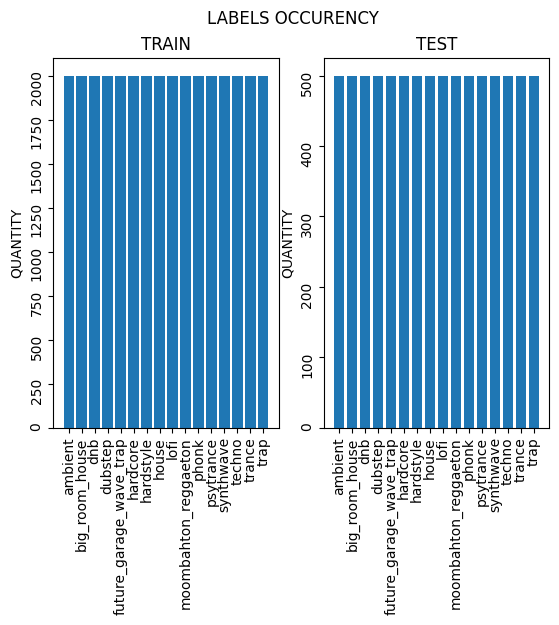

In [108]:
count_labels_train, count_values_train = np.unique(y_train, return_counts=True)
count_labels_test, count_values_test = np.unique(y_test, return_counts=True)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('LABELS OCCURENCY')
ax1.bar(count_labels_train,count_values_train)
ax1.tick_params(labelrotation=90)
ax1.set_ylabel('QUANTITY')
ax1.set_title('TRAIN')
ax2.bar(count_labels_test,count_values_test)
ax2.tick_params(labelrotation=90)
ax2.set_ylabel('QUANTITY')
ax2.set_title('TEST')


In [109]:
encoder = OneHotEncoder() # One-Hot encode for best results
encoder.fit(y_train)
y_train = encoder.transform(y_train).toarray()
y_test = encoder.transform(y_test).toarray()

In [110]:
len(encoder.categories_[0])

16

In [111]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [112]:
class EDMDataset(Dataset):
  def __init__(self,inputs,outputs):
    self.inputs = inputs
    self.outputs = outputs

  def __len__(self):
    return len(self.outputs)

  def __getitem__(self,idx):
    input = self.inputs[idx]
    output = self.outputs[idx]
    return input, output

In [113]:
X_train.shape, X_test.shape

(torch.Size([32000, 130]), torch.Size([8000, 130]))

In [114]:
torch.manual_seed(42)
train_dataloader = DataLoader(EDMDataset(X_train,y_train),batch_size=3200,shuffle=True)
test_dataloader = DataLoader(EDMDataset(X_test,y_test),batch_size=800,shuffle=True)

# Creating Model

In [115]:
class EDMModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(130,130),
        nn.LeakyReLU(inplace=True),
        nn.Linear(130,130),
        nn.LeakyReLU(inplace=True),
        nn.Linear(130,16),
    )

  def forward(self,x):
    return self.layers(x)

In [116]:
torch.manual_seed(42)
model = EDMModel().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=0.003,params=model.parameters())
EPOCHS = 500

# Train and Test Loops

In [117]:
def train_loop(dataloader,model,loss_fn,optimizer):
  global DEVICE

  model.train()
  for X,y in dataloader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    logits = model(X)
    loss = loss_fn(logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [118]:
def test_loop(dataloader,model,loss_fn):
  global DEVICE
  batches = len(dataloader)
  size = len(dataloader.dataset)
  count_loss, count_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      logits = model(X)
      preds = torch.softmax(logits,dim=1).argmax(dim=1)
      count_loss += loss_fn(logits,y).item()
      count_acc += (preds == y.argmax(dim=1)).sum().item()

  avg_loss = count_loss / batches
  avg_acc = count_acc / size
  print(f'AVG_LOSS:{avg_loss} -- AVG_ACC:{avg_acc*100}')
  return avg_loss, avg_acc

# Training and Evaluating the model

In [119]:
losses = []
accs = []

best_acc = 0
best_weights = None

for epoch in range(EPOCHS):
  print(f'EPOCH:{epoch+1}')
  train_loop(train_dataloader,model,loss_fn,optimizer)
  loss, acc = test_loop(test_dataloader,model,loss_fn)

  if acc > best_acc:
    best_acc = acc
    best_weights = copy.deepcopy(model.state_dict())

  losses.append(loss)
  accs.append(acc)
print('DONE!')
model.load_state_dict(best_weights)
print(f'BEST_ACC: {best_acc*100}')
response = input('Do you want to save the model? [y/n]:').upper()
if response == 'Y':
  torch.save(model,'EDMModel_best.pth')

EPOCH:1
AVG_LOSS:54.76974334716797 -- AVG_ACC:5.4
EPOCH:2
AVG_LOSS:8.071426343917846 -- AVG_ACC:17.825
EPOCH:3
AVG_LOSS:2.897535514831543 -- AVG_ACC:14.0875
EPOCH:4
AVG_LOSS:2.52064106464386 -- AVG_ACC:20.0875
EPOCH:5
AVG_LOSS:2.400343108177185 -- AVG_ACC:25.0
EPOCH:6
AVG_LOSS:2.2754966735839846 -- AVG_ACC:26.237500000000004
EPOCH:7
AVG_LOSS:2.1420508146286013 -- AVG_ACC:27.537499999999998
EPOCH:8
AVG_LOSS:2.0635046482086183 -- AVG_ACC:30.599999999999998
EPOCH:9
AVG_LOSS:1.9967991352081298 -- AVG_ACC:33.1625
EPOCH:10
AVG_LOSS:1.9802729606628418 -- AVG_ACC:33.825
EPOCH:11
AVG_LOSS:1.9439876794815063 -- AVG_ACC:34.325
EPOCH:12
AVG_LOSS:1.918180727958679 -- AVG_ACC:34.925
EPOCH:13
AVG_LOSS:1.8816641449928284 -- AVG_ACC:36.1
EPOCH:14
AVG_LOSS:1.8248611092567444 -- AVG_ACC:40.050000000000004
EPOCH:15
AVG_LOSS:1.8208771109580995 -- AVG_ACC:41.1625
EPOCH:16
AVG_LOSS:1.7970973610877992 -- AVG_ACC:41.712500000000006
EPOCH:17
AVG_LOSS:1.7554259657859803 -- AVG_ACC:43.05
EPOCH:18
AVG_LOSS:1.90281

[Text(0.5, 0, 'EPOCH'), Text(0, 0.5, 'ACCURACY')]

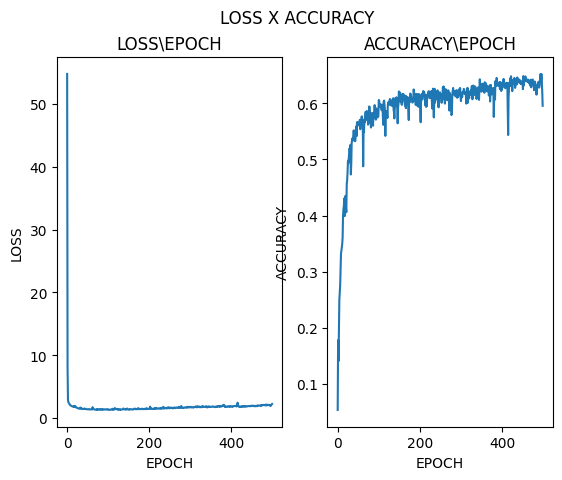

In [120]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('LOSS X ACCURACY')
ax1.plot(losses)
ax1.set_title('LOSS\EPOCH')
ax1.set(xlabel='EPOCH',ylabel='LOSS')
ax2.plot(accs)
ax2.set_title('ACCURACY\EPOCH')
ax2.set(xlabel='EPOCH',ylabel='ACCURACY')

In [121]:
def validate_best_model(dataloader,model):
  global DEVICE, encoder
  all_preds = []
  all_y = []
  classes_array = [0] * len(encoder.categories_[0])
  classes_false_array = [0] * len(encoder.categories_[0])

  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      logits = model(X)
      preds = torch.softmax(logits,dim=1).argmax(dim=1)
      all_preds.append(preds)
      all_y.append(y)
    all_preds = torch.cat(all_preds)
    all_y = torch.cat(all_y).argmax(dim=1)
    for index, target in enumerate(all_y):
      if target == all_preds[index]:
        classes_array[target] += 1
      else:
        classes_false_array[target] +=1

    X = encoder.categories_[0]
    X_axis = np.arange(len(X))
    plt.bar(X_axis - 0.2, classes_array, 0.4, label = 'Correct Preds')
    plt.bar(X_axis + 0.2, classes_false_array, 0.4, label = 'Incorrect Preds')

    plt.xticks(X_axis, X)
    plt.tick_params(labelrotation=90)
    plt.xlabel('Categories')
    plt.ylabel('Number of Preds')
    plt.title('Correct and Incorrect Preds in each Categorie')
    plt.legend()
    plt.show()

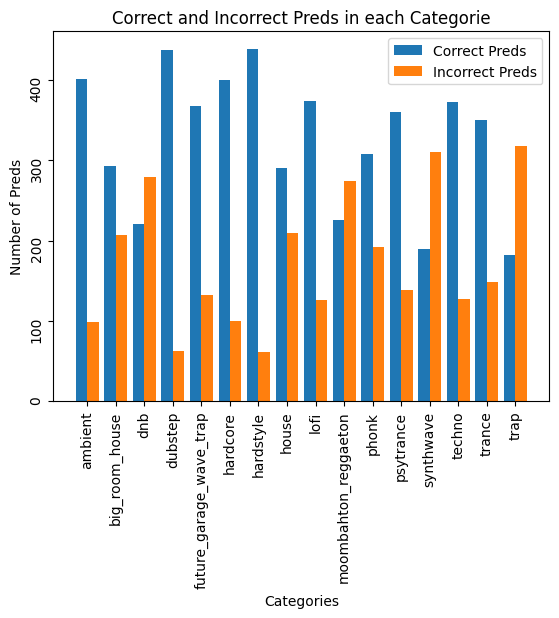

In [122]:
validate_best_model(test_dataloader,model)